In [ ]:
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install statsmodels

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

# Load your historical data
prices = pd.read_csv("prices.txt", delim_whitespace=True, header=None)
# Assign column names for clarity
prices.columns = [f"Stock{i+1}" for i in range(prices.shape[1])]


C:\Users\user\AppData\Local\Temp\ipykernel_5276\2813464023.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  prices = pd.read_csv("prices.txt", delim_whitespace=True, header=None)


In [149]:
# correlation matrix of the prices
corr_matrix = prices.corr()#.abs()
# corr_matrix


In [150]:
#heat matrix of the correlation matrix

''' Uncomment the following lines to visualize the correlation matrix in a heat map '''


# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# figure(figsize=(12, 10), dpi=80)
# sns.heatmap(corr_matrix, annot=False)
# plt.title("Correlation Matrix Heatmap of Stock Prices")
# plt.show()


' Uncomment the following lines to visualize the correlation matrix in a heat map '

In [151]:
corr_unstacked = corr_matrix.unstack()

# Filter out self-correlations and group by pairs and remove the duplicate pairs - CHATGPT did this for me
corr_unstacked = corr_unstacked[corr_unstacked.index.get_level_values(0) != corr_unstacked.index.get_level_values(1)]
corr_unstacked = corr_unstacked.groupby([frozenset(pair) for pair in corr_unstacked.index]).mean()

#we want to find the top pairs with highest correlation that is atleast above 0.8 (**chosen threshold can be adjusted**)
correlation_threshold = 0.8
corr_unstacked = corr_unstacked[np.abs(corr_unstacked) > correlation_threshold]
# Sort the pairs by correlation value
top_pairs = corr_unstacked.sort_values(ascending=False)

print(top_pairs)

(Stock3, Stock7)      0.938054
(Stock21, Stock5)     0.926042
(Stock3, Stock21)     0.918227
(Stock7, Stock5)      0.917858
(Stock3, Stock5)      0.906367
                        ...   
(Stock7, Stock23)    -0.892576
(Stock7, Stock30)    -0.899890
(Stock3, Stock23)    -0.901058
(Stock23, Stock21)   -0.904824
(Stock50, Stock2)    -0.906795
Length: 69, dtype: float64


In [ ]:

import matplotlib.pyplot as plt

#graph of the two pairs with the highest correlation from above
def plot_pair(stock1, stock2, prices):
    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(prices[stock1], label=stock1)
    plt.plot(prices[stock2], label=stock2)
    plt.title(f'{stock1} vs {stock2} – Price Comparison')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

#check out the cointegration value: Null hyp. = no cointegration
#pretty irrelevant now as the function below checks cointegration for all pairs that have a high correlation
# import statsmodels.tsa.stattools as ts
# def check_cointegration(stock1, stock2, prices):
#     result = ts.coint(prices[stock1], prices[stock2])
#     print(f'Cointegration test between {stock1} and {stock2}:')
#     # print(f'  Test Statistic: {result[0]}')
#     print(f'  p-value: {result[1]}')
#     # print(f'  Critical Values: {result[2]}')
#     print(f'WANT p-value < 0.05 for cointegration (shows that cointegration exists)')

In [153]:
#loop through the top pairs and check cointegration

from statsmodels.tsa.stattools import coint

def check_cointegration_all(top_pairs, prices, pval_threshold=0.05):
    cointegrated_pairs = []
    for pair in top_pairs.index:
        stock1, stock2 = tuple(pair)
        series1 = prices[stock1]
        series2 = prices[stock2]
        score, p_value, _ = coint(series1, series2)
        if p_value < pval_threshold:
            correlation_value = corr_matrix.loc[stock1, stock2]
            cointegrated_pairs.append((stock1, stock2, p_value, correlation_value))
    return pd.DataFrame(cointegrated_pairs, columns=['Stock A', 'Stock B', 'p-value', 'Corr Val'])

In [164]:
# Get the top pairs and check cointegration
print(f'Wanted a p-value < 0.05 for cointegration (shows that cointegration exists) this resulted in the following cointegrated pairs that had a > 0.8 correlation:')
cointegrated_pairs = check_cointegration_all(top_pairs, prices)
print("Cointegrated Pairs:")
print(cointegrated_pairs)

Wanted a p-value < 0.05 for cointegration (shows that cointegration exists) this resulted in the following cointegrated pairs that had a > 0.8 correlation:
Cointegrated Pairs:
    Stock A  Stock B   p-value  Corr Val
0    Stock3   Stock7  0.007999  0.938054
1    Stock3  Stock21  0.022754  0.918227
2   Stock12  Stock24  0.005177  0.902666
3   Stock34   Stock2  0.011937  0.899330
4   Stock43  Stock30  0.016061  0.897304
5   Stock23  Stock30  0.029159  0.864354
6   Stock12  Stock14  0.037536  0.818642
7   Stock32  Stock15  0.037466  0.812515
8    Stock8  Stock14  0.025605  0.806911
9   Stock49  Stock50  0.000028  0.801410
10  Stock50  Stock26  0.011013 -0.839795
11  Stock34  Stock50  0.000066 -0.866320
12  Stock17  Stock30  0.037261 -0.885211
13   Stock7  Stock23  0.020011 -0.892576
14   Stock3  Stock23  0.035687 -0.901058
15  Stock23  Stock21  0.014386 -0.904824
16  Stock50   Stock2  0.003220 -0.906795


In [166]:
#plot the spread between the two pairs with the highest correlation
def plot_spread(stock1, stock2, prices):
    price1 = prices[stock1]
    price2 = prices[stock2]

    beta = np.cov(price1, price2)[0, 1] / np.var(price2)
    spread = price1 - beta * price2

    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(spread, label=f'Spread: Stock {stock1} - {beta:.2f} * {stock2}', color='orange')
    plt.axhline(spread.mean(), color='black', label='Mean')
    plt.axhline(spread.mean() + spread.std(), color='red', linestyle='--', label='+1 Std')
    plt.axhline(spread.mean() - spread.std(), color='green', linestyle='--', label='-1 Std')
    plt.title(f'Spread between Stock {stock1} and Stock {stock2}')
    plt.xlabel('Days')
    plt.ylabel('Spread Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [162]:
#can also check out the price ratio between the two pairs with the highest correlation
def plot_price_ratio(stock1, stock2, prices):
    ratio = prices[stock1] / prices[stock2]
    plt.figure(figsize=(10, 5), dpi=80)
    plt.plot(ratio, label=f'Price Ratio: {stock1} / {stock2}', color='purple')
    plt.axhline(ratio.mean(), color='black')
    plt.title(f'Price Ratio between Stock {stock1} and Stock {stock2}')
    plt.xlabel('Days')
    plt.ylabel('Price Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

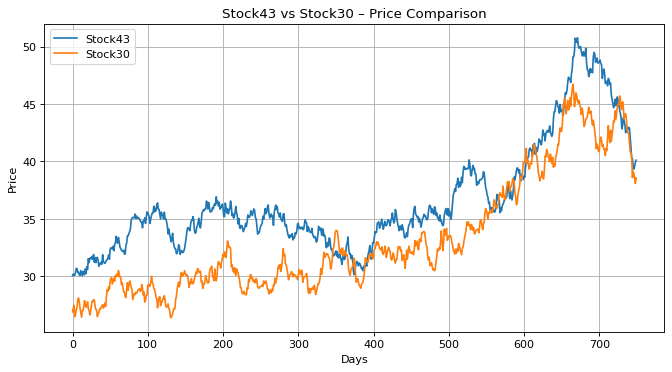

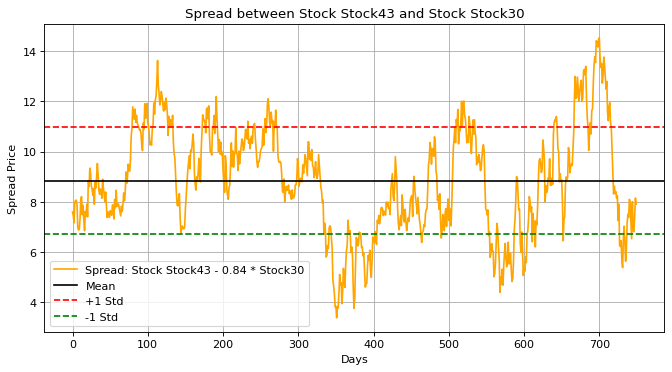

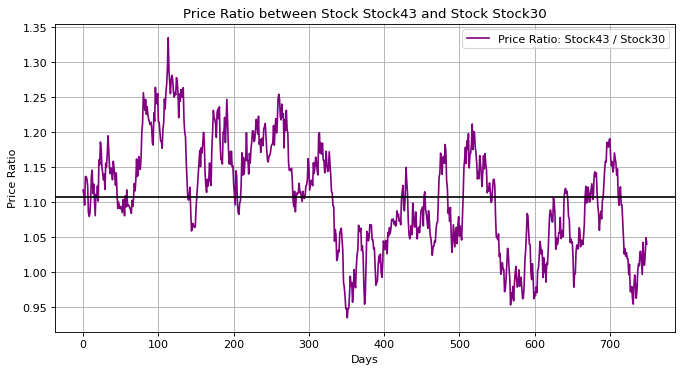

In [167]:
plot_pair('Stock43', 'Stock30', prices)
plot_spread('Stock43', 'Stock30', prices)
plot_price_ratio('Stock43', 'Stock30', prices)

In [180]:
#calculating z scores for the ratio spread then plotting them
def zscore(series):
    return (series - series.mean()) / np.std(series)

def plot_zscore_ratio(stock1, stock2, prices):
    ratio = prices[stock1] / prices[stock2]
    zscore(ratio).plot(figsize=(10,5))
    plt.axhline(zscore(ratio).mean())
    plt.axhline(1.0, color='red')
    plt.axhline(-1.0, color='green')
    plt.title(f'Z-Score of Price Ratio between {stock1} and {stock2}')
    plt.xlabel('Days')
    plt.ylabel('Z-Score')
    plt.show()

def plot_zscore_of_spread(stock1, stock2, prices):
    price1 = prices[stock1]
    price2 = prices[stock2]

    # Hedge ratio using OLS
    beta = np.cov(price1, price2)[0, 1] / np.var(price2)

    # Compute spread
    spread = price1 - beta * price2

    # Compute z-score of the spread
    z = zscore(spread)

    # Plot z-score
    plt.figure(figsize=(10,5))
    plt.plot(z, label='Z-score of Spread', color='blue')
    plt.axhline(0, color='black')
    plt.axhline(1.0, color='red', label='+1')
    plt.axhline(-1.0, color='green', label='-1')
    plt.title(f'Z-score of Spread: Stock {stock1} - {beta:.2f} × Stock {stock2}')
    plt.xlabel('Days')
    plt.ylabel('Z-score')
    plt.legend()
    plt.grid(True)
    plt.show()


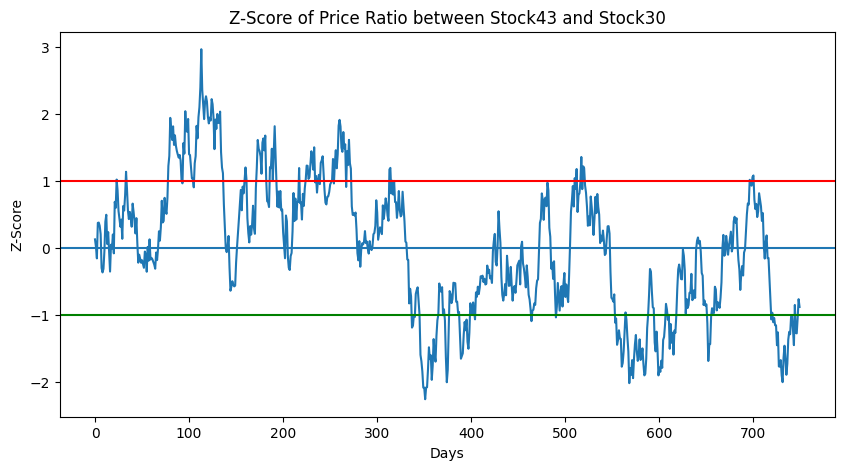

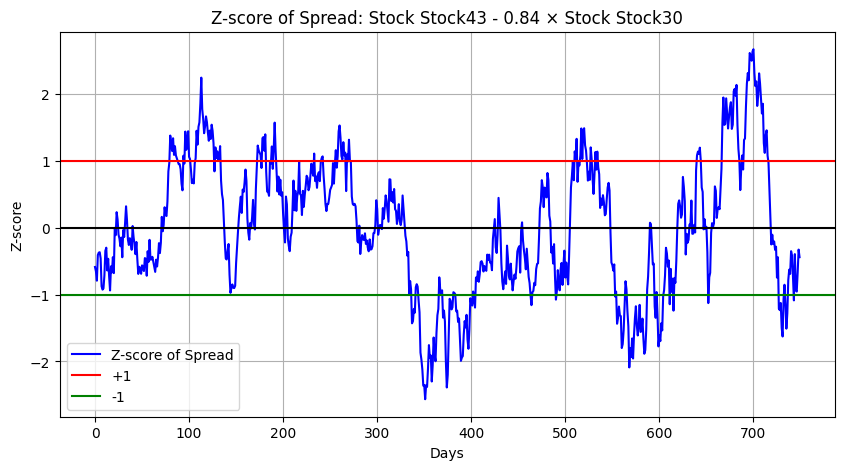

In [181]:
plot_zscore_ratio('Stock43', 'Stock30', prices)
plot_zscore_of_spread('Stock43', 'Stock30', prices)